In [1]:
import sys
import cebra
import os
import tempfile
import torch
import pandas as pd
import numpy as np
import pickle as pkl
import matplotlib
import cebra.models
from torch import nn
from scipy import stats
from cebra import CEBRA
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib.colors import rgb2hex
from matplotlib.colors import LinearSegmentedColormap
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import r2_score, f1_score
sys.path.append('/home/garullie/CEBRA_analysis/')
from dataset_load import data_load
from cebra.models.model import _OffsetModel, ConvolutionalModelMixin


In [2]:
@cebra.models.register("offset200-model") # --> add that line to register the model!
class Offset200Model(_OffsetModel, ConvolutionalModelMixin):

    def __init__(self, num_neurons, num_units, num_output, normalize=True):
        super().__init__(
            
            nn.Conv1d(num_neurons, num_units, 101),
            nn.GELU(),
            nn.Conv1d(num_units, num_units, 21),
            nn.GELU(),
            nn.Conv1d(num_units, num_units, 21),
            nn.GELU(),
            nn.Conv1d(num_units, num_units, 21),
            nn.GELU(),
            nn.Conv1d(num_units, num_units, 21),
            nn.GELU(),
            nn.Conv1d(num_units, num_output, 20),
            num_input=num_neurons,
            num_output=num_output,
            normalize=normalize,
        )

    # ... and you can also redefine the forward method,
    # as you would for a typical pytorch model

    def get_offset(self) -> cebra.data.datatypes.Offset:
        return cebra.data.Offset(100, 100)

In [3]:
print(cebra.models.get_options('offset200-model'))


['offset200-model']


In [4]:
skipdates = ["220818", "220819"]
input_folder = "/sc-projects/sc-proj-cc15-ag-wenger-retune/data_kinematic_states_neural/"
VICON_FS = 200
variables_to_drop = ["ANIMAL_ID", "CONDITION", "RUN", "DATE", "EVENT", "ECOG_LEFT_fooof_a_knee", "ECOG_RIGHT_fooof_a_knee"]
data_dict = data_load(input_folder, variables_to_drop, skipdates)
x = data_dict["X_pd"]
y = data_dict["y_pd"]
animals_id = data_dict["animals_id_pd"]
run_id = data_dict["run_id_pd"]
groups = [a+i for a, i in zip(animals_id, run_id)]
rng = np.random.default_rng(seed=42) 
unique_groups = np.unique(groups)  
rng.shuffle(unique_groups)   
gkf = GroupKFold(n_splits=11)
gkf.get_n_splits(groups=groups)

X_unique = np.arange(len(unique_groups))  

No file found for 230425 NWE00161 02
No file found for 230425 NWE00161 08
No file found for 230425 NWE00160 04
No file found for 230425 NWE00160 03
No file found for 230425 NWE00164 21


In [5]:
type(pd.DataFrame(x.loc[:, "ECOG_LEFT_fft_high beta"]))

pandas.core.frame.DataFrame

In [8]:
loaded_cebra_model = cebra.CEBRA.load("./models/run_splits_0_beta.pt")

<Axes: xlabel='Steps', ylabel='InfoNCE Loss'>

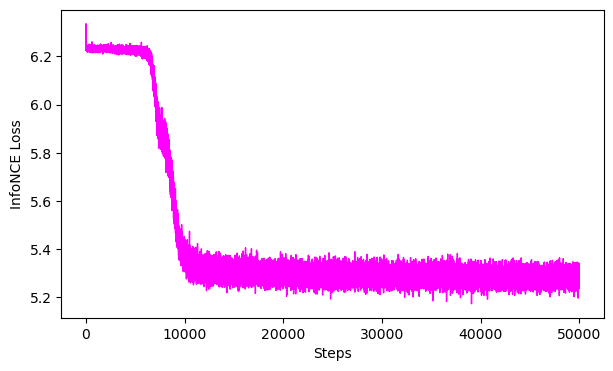

In [9]:
cebra.plot_loss(loaded_cebra_model)

In [11]:
embedding = loaded_cebra_model.transform(pd.DataFrame(x.loc[:, "ECOG_LEFT_fft_high beta"]))
#test_embedding = loaded_cebra_model.transform(X_test)

In [12]:
colors = ["cyan", "#2e2d4d", "m"]
n_bins = [0, 1, 2]  # Discretizes the interpolation into bins
cmap_name = 'neurokin'
cmap = LinearSegmentedColormap.from_list(cmap_name, colors)

(-1.0, 1.0, -1.0, 1.0, -1.0, 1.0)

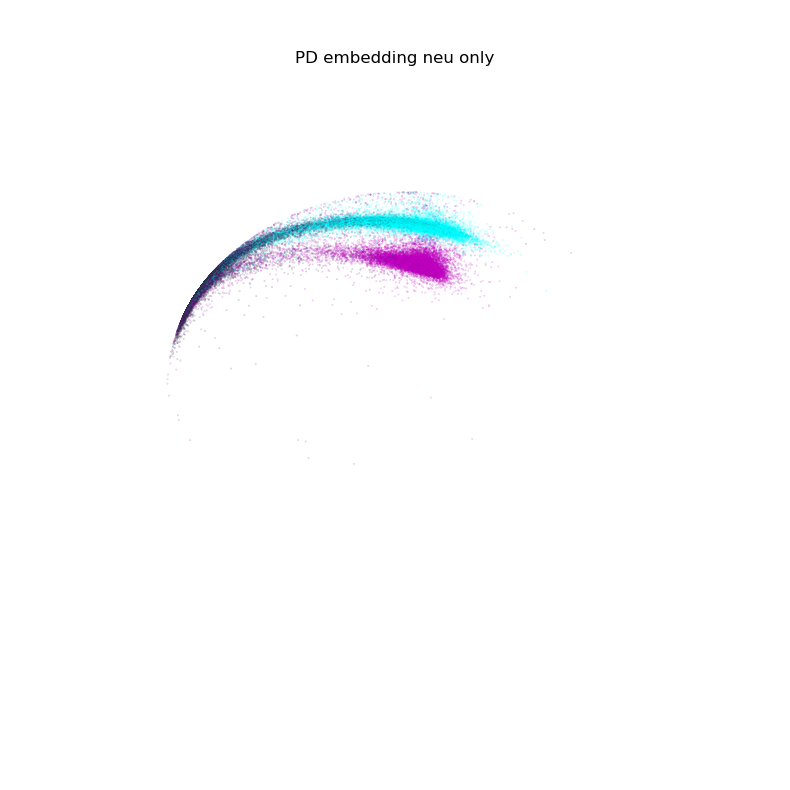

In [13]:
ax = cebra.plot_embedding(embedding=embedding, embedding_labels=y, title="PD embedding neu only", cmap=cmap, figsize=(10,10))
ax.set_zlim(-1, 1)
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.azim = 150
#ax.elev = 30
ax.axis("off")
#plt.savefig("cebra_neural_full.png", transparent=True, dpi=300)
#plt.savefig("cebra_neural_full.svg", transparent=True, dpi=100)

In [14]:
confusion_matrixes = []
f1_scores = []
for i in range(11):
    with open(f"./neural_predictions/predictions_neu_{i}_beta.pkl", "rb") as input_file:
        knn_results = pkl.load(input_file)
        f1_scores.append(f1_score(knn_results["true"], knn_results["prediction"], average="weighted"))
        tr = np.where(knn_results["true"]==0, 0, 1)
        pred = np.where(knn_results["prediction"]==0, 0, 1)
        cm = confusion_matrix(tr, pred, labels=[0,1], normalize="true")
    #cm = confusion_matrix(knn_results["true"], knn_results["prediction"], labels=[0,1,2], normalize="true")
    confusion_matrixes.append(cm)
pd_avg_confusion_matrixes = np.mean(confusion_matrixes, axis=0)
pd_std_confusion_matrixes = np.std(confusion_matrixes, axis=0)

In [15]:
np.mean(f1_scores)

0.46579484974580443

[]

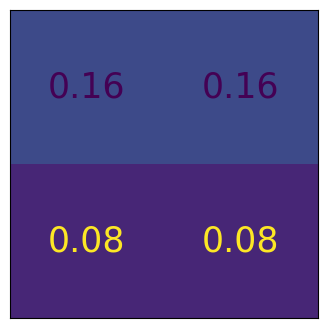

In [16]:
fig, ax = plt.subplots(figsize=(4,4))
text_kw = {"fontsize":25}
disp = ConfusionMatrixDisplay(confusion_matrix=pd_std_confusion_matrixes, display_labels=[0,1])
disp.plot(ax=ax, colorbar=False, values_format=".2f", text_kw=text_kw)
disp.im_.set_clim(vmin=0, vmax=0.7)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([], [])
ax.set_yticks([], [])
#plt.savefig("cm_std.svg", transparent=True)

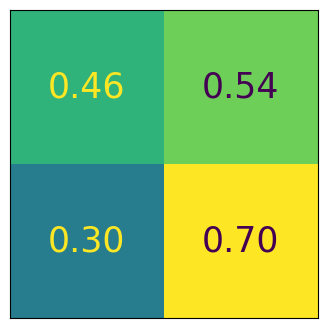

In [17]:
fig, ax = plt.subplots(figsize=(4,4))
text_kw = {"fontsize":25}
disp = ConfusionMatrixDisplay(confusion_matrix=pd_avg_confusion_matrixes, display_labels=[0,1])
disp.plot(ax=ax, colorbar=False, values_format=".2f", text_kw=text_kw)
disp.im_.set_clim(vmin=0, vmax=0.7)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([], [])
ax.set_yticks([], [])
plt.savefig("cm.svg", transparent=True)

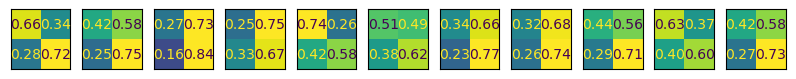

In [18]:
fig, ax = plt.subplots(1, 11, figsize=(10,2))
text_kw = {"fontsize":10}
for i, cm in enumerate(confusion_matrixes):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(ax=ax[i], colorbar=False, values_format=".2f", text_kw=text_kw)
    disp.im_.set_clim(vmin=0, vmax=0.7)
    ax[i].set_xlabel("")
    ax[i].set_ylabel("")
    ax[i].set_xticks([], [])
    ax[i].set_yticks([], [])


In [19]:
tp = pd_avg_confusion_matrixes[0,0]
tn = pd_avg_confusion_matrixes[1,1]
fn = pd_avg_confusion_matrixes[1,0]
fp = pd_avg_confusion_matrixes[0,1]
accuracy = (tp+tn)/(tp+tn+fp+fn)
accuracy

0.5795405013684672

In [20]:
f1 = (2*tp)/(2*tp+fp+fn)
f1

0.519886978900942

In [21]:
confusion_matrixes = []
f1_scores = []
for i in range(11):
    with open(f"./neural_predictions/predictions_neu_{i}_beta.pkl", "rb") as input_file:
        knn_results = pkl.load(input_file)
        f1_scores.append(f1_score(knn_results["true"], knn_results["prediction"], average="weighted"))
        cm = confusion_matrix(knn_results["true"], knn_results["prediction"], labels=[0,1,2], normalize="true")
    #cm = confusion_matrix(knn_results["true"], knn_results["prediction"], labels=[0,1,2], normalize="true")
    confusion_matrixes.append(cm)
pd_avg_confusion_matrixes = np.mean(confusion_matrixes, axis=0)
pd_std_confusion_matrixes = np.std(confusion_matrixes, axis=0)

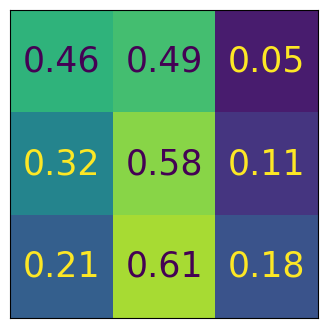

In [22]:
fig, ax = plt.subplots(figsize=(4,4))
text_kw = {"fontsize":25}
disp = ConfusionMatrixDisplay(confusion_matrix=pd_avg_confusion_matrixes, display_labels=[0,1,2])
disp.plot(ax=ax, colorbar=False, values_format=".2f", text_kw=text_kw)
disp.im_.set_clim(vmin=0, vmax=0.7)
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_xticks([], [])
ax.set_yticks([], [])
plt.savefig("cm_3cat.svg", transparent=True)